In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [2]:
def preprocess_image(img_path, size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    plt.imshow(cv2.cvtColor(np.uint8(superimposed_img), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Grad-CAM")
    plt.show()



In [41]:

# Load your trained model
model1 = tf.keras.models.load_model("./final models/t2_breast_VGGAdam-epoch10.keras")  # Replace with your file
# Replace with your actual conv layer name
last_conv_layer_name1 = "block5_conv3"

# Load your trained model
model2 = tf.keras.models.load_model("./final models/t3_breast_IRNAdam_NoPreProcess-epoch12.keras")  # Replace with your file
# Replace with your actual conv layer name
last_conv_layer_name2 = "block8_10_conv"

# Load your trained model
model3 = tf.keras.models.load_model("./final models/t3_breast_ResNet50_NoPreProcess-epoch15.keras")  # Replace with your file
# Replace with your actual conv layer name
last_conv_layer_name3 = "conv5_block3_out"

# Load your trained model
model4 = tf.keras.models.load_model("./final models/t3_breast_Xception_NoPreProcess-lrreduceP4-epoch02.keras")  # Replace with your file
# Replace with your actual conv layer name
last_conv_layer_name4 = "conv2d_3"


In [20]:
img_path_A = "../breast_full_dataset/Malignant/20586934 (7).png"


img_path_B = "../breast_full_dataset/Benign/20586908 (10).png"



In [ ]:
# Run Grad-CAM
img_array_A, _ = preprocess_image(img_path_A)
img_array_B, _ = preprocess_image(img_path_B)

VGG


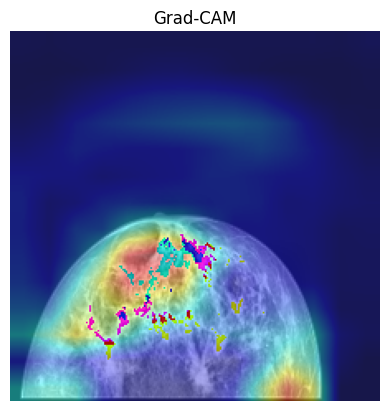

In [45]:
print("VGG")
heatmap = make_gradcam_heatmap(img_array_A, model1, last_conv_layer_name1)
display_gradcam(img_path_A, heatmap)

IRN_V2


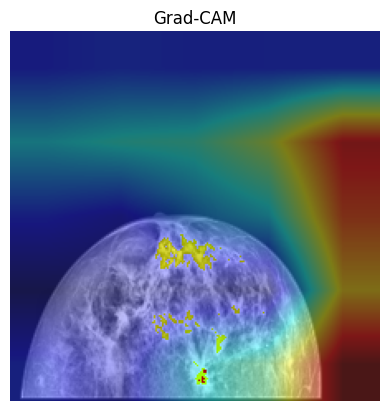

In [47]:
print("IRN_V2")
heatmap = make_gradcam_heatmap(img_array_A, model2, last_conv_layer_name2)
display_gradcam(img_path_A, heatmap)

ResNet50


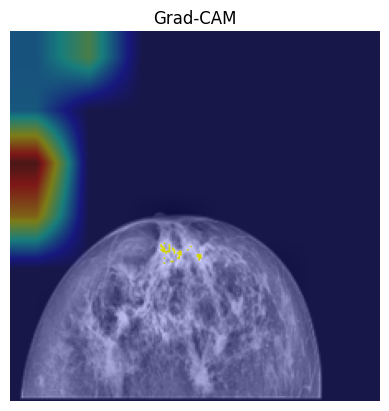

In [49]:
print("ResNet50")
heatmap = make_gradcam_heatmap(img_array_A, model3, last_conv_layer_name3)
display_gradcam(img_path_A, heatmap)

Xception


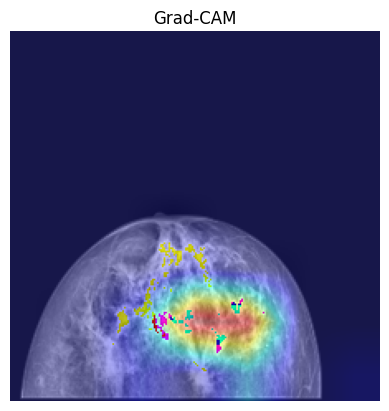

In [50]:
print("Xception")
heatmap = make_gradcam_heatmap(img_array_A, model4, last_conv_layer_name4)
display_gradcam(img_path_A, heatmap)

VGG


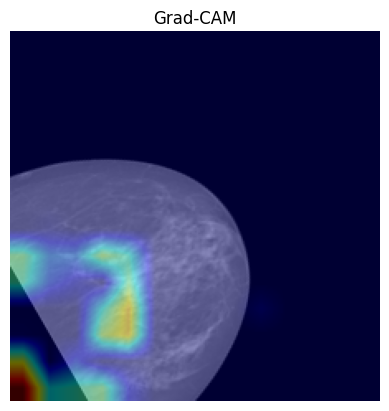

In [51]:
print("VGG")
heatmap = make_gradcam_heatmap(img_array_B, model1, last_conv_layer_name1)
display_gradcam(img_path_B, heatmap)

IRN_V2


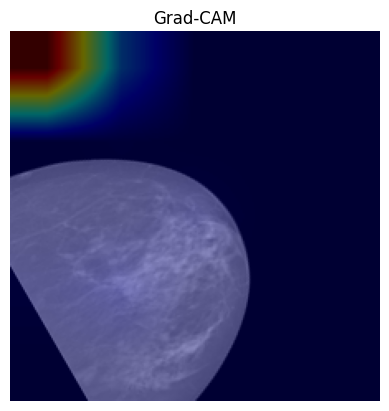

In [52]:
print("IRN_V2")
heatmap = make_gradcam_heatmap(img_array_B, model2, last_conv_layer_name2)
display_gradcam(img_path_B, heatmap)

ResNet50


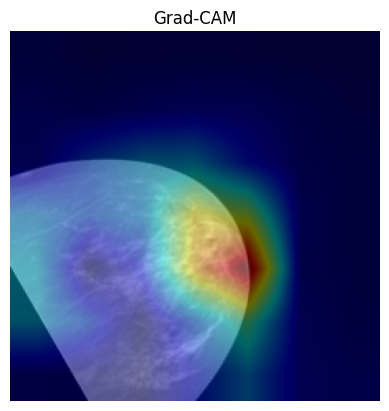

In [53]:
print("ResNet50")
heatmap = make_gradcam_heatmap(img_array_B, model3, last_conv_layer_name3)
display_gradcam(img_path_B, heatmap)

Xception


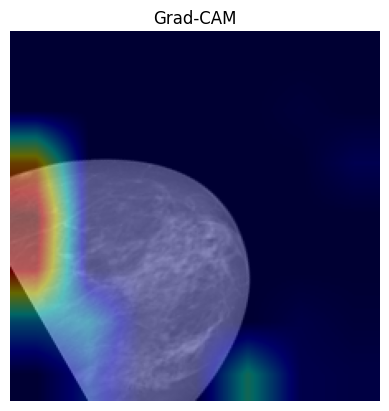

In [54]:
print("Xception")
heatmap = make_gradcam_heatmap(img_array_B, model4, last_conv_layer_name4)
display_gradcam(img_path_B, heatmap)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


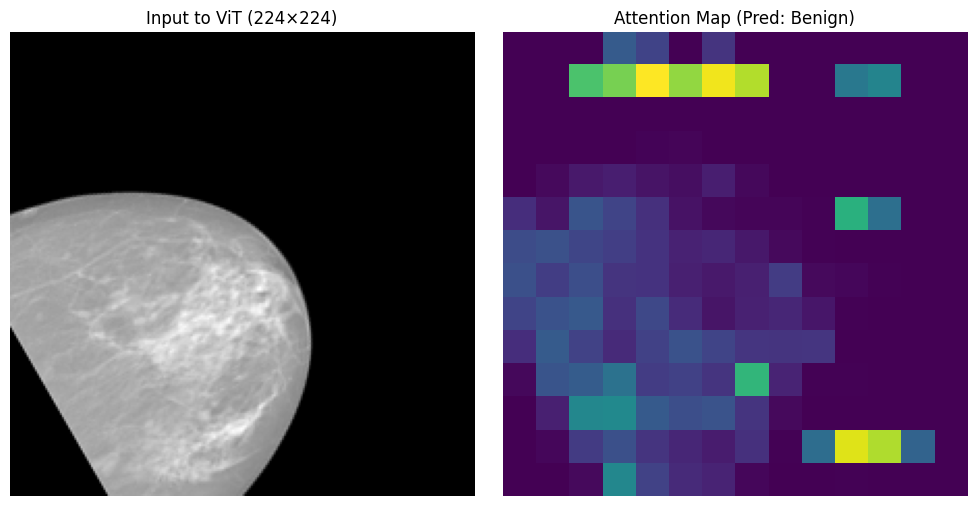

In [24]:
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# === Load model
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=2,
    output_attentions=True
)
model.load_state_dict(torch.load('./final models/t2_breast_vit_NoPreProcess_hdp0.2_adp0.2_lr1e-05-epoch4.pt', map_location='cpu'))
model.eval()

# === Load feature extractor (used during training)
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# === Load and preprocess image
image = Image.open(img_path_B).convert('RGB')
inputs = feature_extractor(images=image, return_tensors="pt")

# === Get tensor that goes into model
input_tensor = inputs['pixel_values'][0]  # shape: (3, 224, 224)

# === Forward pass
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()
    attentions = outputs.attentions

# === Extract attention map (last layer, head 0)
last_layer_attention = attentions[-1]  # [1, 12, 197, 197]
cls_attention = last_layer_attention[0, 0, 0, 1:]  # CLS token → patch tokens
attention_map = cls_attention.reshape(14, 14).numpy()

# === Plot input image (after resizing + normalization) and attention map side-by-side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Show preprocessed image (what the model sees)
img_np = input_tensor.permute(1, 2, 0).numpy()  # (224, 224, 3)
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # Rescale for display
axs[0].imshow(img_np)
axs[0].set_title("Input to ViT (224×224)")
axs[0].axis('off')

# Show attention map
axs[1].imshow(attention_map, cmap='viridis')
axs[1].set_title(f"Attention Map (Pred: {'Benign' if prediction==0 else 'Malignant'})")
axs[1].axis('off')

plt.tight_layout()
plt.show()
